# PyTorch-Beispiele (CPU vs GPU, Datenkopieren, Blur via conv2d)


In [1]:
# Setup: Imports + Device-Auswahl
import time

try:
    import torch
    import torch.nn.functional as F
    TORCH_OK = True
except Exception as e:
    TORCH_OK = False
    print('PyTorch ist nicht verfügbar:', repr(e))
    print('Installation (Beispiel): pip install torch --index-url https://download.pytorch.org/whl/cpu')

if TORCH_OK:
    def pick_device() -> str:
        if torch.cuda.is_available():
            return 'cuda'
        mps_ok = hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()
        if mps_ok:
            return 'mps'
        return 'cpu'

    def sync(device: str) -> None:
        # CUDA und MPS sind asynchron → für faire Timings synchronisieren
        if device == 'cuda':
            torch.cuda.synchronize()
        elif device == 'mps':
            if hasattr(torch, 'mps') and hasattr(torch.mps, 'synchronize'):
                torch.mps.synchronize()

    dev = pick_device()
    print('torch:', torch.__version__)
    print('device:', dev)
    print('cuda available:', torch.cuda.is_available())
    print('mps available:', hasattr(torch.backends, 'mps') and torch.backends.mps.is_available())
    if dev == 'cuda':
        print('GPU:', torch.cuda.get_device_name(0))

torch: 2.5.1
device: mps
cuda available: False
mps available: True


## CPU vs GPU (Matrixmultiplikation)

Ziel: zeigen, dass die GPU besonders stark bei großen Matrixrechnungen ist – **wenn** die Daten auf der GPU bleiben.

In [4]:
if TORCH_OK:
    def run_mm(n: int, device: str, iters: int = 10, warmup: int = 3) -> float:
        """Zeit pro MatMul in Sekunden (Durchschnitt über iters)."""
        a = torch.randn(n, n, device=device)
        b = torch.randn(n, n, device=device)

        for _ in range(warmup):
            _ = a @ b
        sync(device)

        t0 = time.perf_counter()
        for _ in range(iters):
            _ = a @ b
        sync(device)
        return (time.perf_counter() - t0) / iters

    sizes = [1024, 2048, 4096]
    print('Zeit pro MatMul (s) für verschiedene Größen n x n:')
    print('n	CPU		' + (dev.upper() if dev != 'cpu' else 'GPU'))
    for n in sizes:
        cpu_t = run_mm(n, 'cpu', iters=10)
        if dev != 'cpu':
            dev_t = run_mm(n, dev, iters=10)
            print(f'{n}	{cpu_t:.6f}	{dev_t:.6f}')
        else:
            print(f'{n}	{cpu_t:.6f}	-')

    if dev == 'cpu':
        print('GPU: nicht verfügbar (weder CUDA noch MPS)')

Zeit pro MatMul (s) für verschiedene Größen n x n:
n	CPU		MPS
1024	0.001945	0.002436
2048	0.015646	0.007268
4096	0.124692	0.058642


## Typischer Fehler: zu viel Kopieren

Merksatz: **Einmal kopieren, dann viel rechnen.**

Unten messen wir grob den Unterschied zwischen (a) in jeder Iteration `.to(device)` und (b) einmal vorab kopieren.

In [5]:
if TORCH_OK:
    # Kleine Größen wählen, damit es überall schnell läuft
    xs = [torch.randn(512, 512) for _ in range(20)]  # CPU-Tensoren

    def time_bad(xs_cpu, device: str):
        if device == 'cpu':
            return None
        t0 = time.time()
        for x in xs_cpu:
            _ = (x.to(device) @ x.to(device))
        sync(device)
        return time.time() - t0

    def time_better(xs_cpu, device: str):
        if device == 'cpu':
            return None
        xs_dev = [x.to(device) for x in xs_cpu]
        sync(device)
        t0 = time.time()
        for x in xs_dev:
            _ = (x @ x)
        sync(device)
        return time.time() - t0

    tb = time_bad(xs, dev)
    tg = time_better(xs, dev)

    if tb is None:
        print('GPU nicht verfügbar → Kopier-Beispiel übersprungen.')
    else:
        print(f'schlecht (jede Runde kopieren → {dev}):', tb)
        print(f'besser  (einmal kopieren → {dev}):     ', tg)

schlecht (jede Runde kopieren → mps): 0.06306672096252441
besser  (einmal kopieren → mps):      0.00831913948059082


## Blur als Faltung (conv2d)

Ein einfacher Box-Blur ist eine Faltung: jeder Output-Pixel wird nach dem gleichen Rezept aus Nachbarn berechnet → sehr GPU-freundlich.

img: (1, 1, 256, 256) mps:0
out: (1, 1, 256, 256) mps:0


Matplotlib is building the font cache; this may take a moment.


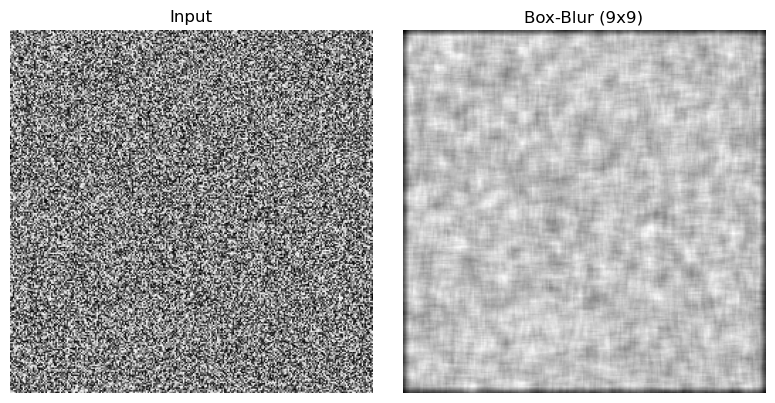

In [6]:
if TORCH_OK:
    img = torch.rand(1, 1, 256, 256, device=dev)  # N,C,H,W

    k = torch.ones(1, 1, 9, 9, device=dev) / (9 * 9)
    try:
        out = F.conv2d(img, k, padding=4)
    except Exception as e:
        print('conv2d auf', dev, 'fehlgeschlagen → fallback auf CPU:', repr(e))
        img = img.to('cpu')
        k = k.to('cpu')
        out = F.conv2d(img, k, padding=4)

    print('img:', tuple(img.shape), img.device)
    print('out:', tuple(out.shape), out.device)

    # Optional: Visualisierung (wenn matplotlib installiert ist)
    try:
        import matplotlib.pyplot as plt

        img_cpu = img[0, 0].detach().float().cpu().numpy()
        out_cpu = out[0, 0].detach().float().cpu().numpy()

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(img_cpu, cmap='gray')
        ax[0].set_title('Input')
        ax[0].axis('off')
        ax[1].imshow(out_cpu, cmap='gray')
        ax[1].set_title('Box-Blur (9x9)')
        ax[1].axis('off')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print('matplotlib nicht verfügbar (optional):', repr(e))

## Datentransfer: CPU ↔ GPU (Bandbreite/Overhead)

Dieses Beispiel misst grob die Zeit, um Tensoren zwischen CPU und dem aktuellen Device (`cuda` oder `mps`) zu kopieren.

Wichtig:
- Bei `cuda` entspricht das typischerweise Transfers über PCIe (klassischer CPU-RAM ↔ GPU-VRAM).
- Bei `mps` (Apple Silicon) ist die Speicherarchitektur anders (Unified Memory). Die Messung ist trotzdem nützlich, aber nicht 1:1 mit PCIe/CUDA vergleichbar.

In [12]:
if TORCH_OK:
    if dev == 'cpu':
        print('Kein GPU-Device verfügbar (dev=cpu) → Transfer-Benchmark übersprungen.')
    else:
        
        def tensor_nbytes(t: torch.Tensor) -> int:
            return t.numel() * t.element_size()
        
        def format_gbs(nbytes: int, seconds: float) -> str:
            if seconds <= 0:
                return '-'
            return f"{(nbytes / seconds) / 1e9:.2f} GB/s"
        
        def bench_copy_cpu_to_dev(nbytes: int, device: str, iters: int = 20) -> tuple[float, int]:
            # 1D float32 tensor mit ungefähr nbytes (mind. 1 Element)
            elem_size = 4
            n = max(1, nbytes // elem_size)
            x = torch.empty(n, dtype=torch.float32, device='cpu')
            
            # warm-up
            _ = x.to(device)
            sync(device)
            
            t0 = time.perf_counter()
            for _ in range(iters):
                _ = x.to(device)
            sync(device)
            dt = (time.perf_counter() - t0) / iters
            return dt, tensor_nbytes(x)
        
        def bench_copy_dev_to_cpu(nbytes: int, device: str, iters: int = 20) -> tuple[float, int]:
            elem_size = 4
            n = max(1, nbytes // elem_size)
            x = torch.empty(n, dtype=torch.float32, device=device)
            
            # warm-up
            _ = x.to('cpu')
            sync(device)
            
            t0 = time.perf_counter()
            for _ in range(iters):
                _ = x.to('cpu')
            sync(device)
            dt = (time.perf_counter() - t0) / iters
            return dt, tensor_nbytes(x)
        
        # Größere Transfers zeigen eher die 'Bandbreite' (kleine Transfers sind Overhead-dominiert)
        # Achtung: Sehr große Größen können je nach RAM/Unified-Memory zu OOM/Swap führen.
        # Kleine Größen (KB-Bereich) zeigen v.a. Overhead; große Größen zeigen eher Bandbreite
        sizes_mb = [0.0625, 0.25, 0.5, 1, 16, 64, 256, 512, 1024, 2048, 4096]
        print(f"Device: {dev}")
        print("Größe (MB)\tCPU→DEV\t\tDEV→CPU")
        for mb in sizes_mb:
            nbytes = int(mb * 1024 * 1024)
            # Weniger Wiederholungen bei großen Transfers (sonst dauert es lange)
            iters = 200 if mb < 1 else (30 if mb <= 16 else (10 if mb <= 256 else (3 if mb <= 1024 else 1)))
            try:
                dt_h2d, real_bytes = bench_copy_cpu_to_dev(nbytes, dev, iters=iters)
                dt_d2h, _ = bench_copy_dev_to_cpu(nbytes, dev, iters=iters)
            except Exception as e:
                print(f"{mb:>7.2f} MB\tübersprungen ({type(e).__name__}: {e})")
                break
            print(
                f"{mb:>7.2f} MB\t"
                f"{dt_h2d*1e3:7.2f} ms ({format_gbs(real_bytes, dt_h2d)})\t"
                f"{dt_d2h*1e3:7.2f} ms ({format_gbs(real_bytes, dt_d2h)})"
            )
        
        print()
        print("Interpretation:")
        print("- Kleine Transfers sind oft von Overhead dominiert (ms, niedrige GB/s).")
        print("- Große Transfers nähern sich eher einer 'Bandbreite' an.")
        if dev == 'mps':
            print("- Bei MPS können Werte wegen Unified Memory anders aussehen als PCIe/CUDA.")

Device: mps
Größe (MB)	CPU→DEV		DEV→CPU
   0.06 MB	   0.19 ms (0.34 GB/s)	   0.16 ms (0.41 GB/s)
   0.25 MB	   0.17 ms (1.52 GB/s)	   0.17 ms (1.53 GB/s)
   0.50 MB	   0.18 ms (2.90 GB/s)	   0.19 ms (2.74 GB/s)
   1.00 MB	   0.23 ms (4.51 GB/s)	   0.18 ms (5.77 GB/s)
  16.00 MB	   0.76 ms (22.11 GB/s)	   0.75 ms (22.44 GB/s)
  64.00 MB	   2.37 ms (28.31 GB/s)	   2.48 ms (27.01 GB/s)
 256.00 MB	  10.29 ms (26.08 GB/s)	  16.38 ms (16.38 GB/s)
 512.00 MB	  25.61 ms (20.96 GB/s)	  30.60 ms (17.55 GB/s)
1024.00 MB	  39.46 ms (27.21 GB/s)	 105.57 ms (10.17 GB/s)
2048.00 MB	  77.20 ms (27.82 GB/s)	 154.89 ms (13.86 GB/s)
4096.00 MB	 173.41 ms (24.77 GB/s)	 497.30 ms (8.64 GB/s)

Interpretation:
- Kleine Transfers sind oft von Overhead dominiert (ms, niedrige GB/s).
- Große Transfers nähern sich eher einer 'Bandbreite' an.
- Bei MPS können Werte wegen Unified Memory anders aussehen als PCIe/CUDA.
